# Learning Curves of Lucie-7B

In [1]:
import slugify
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import numpy as np

### 1. Load all benchmark results

Load CSV files ([evaluation_learning_curve_lucie.csv](evaluation_learning_curve_lucie.csv) and [evaluation_baselines.csv](evaluation_baselines.csv)).

In [2]:
# !pip install pandas matplotlib seaborn python-slugify
lucie_results = pd.read_csv(
    "../evaluation_learning_curve_lucie.csv"
)
baseline_results = pd.read_csv(
    "../evaluation_baselines.csv"
)

# Print some statistics
def unique(field): return len(lucie_results[field].unique())
print(f"✅ {unique('training_tokens')} Lucie checkpoints evaluated on {unique('benchmark')} benchmarks ({unique('dataset')} datasets)")
def unique(field): return len(baseline_results[field].unique())
print(f"✅ {unique('model_name')} baseline checkpoints evaluated on {unique('benchmark')} benchmarks ({unique('dataset')} datasets)")

✅ 45 Lucie checkpoints evaluated on 6 benchmarks (192 datasets)
✅ 9 baseline checkpoints evaluated on 5 benchmarks (184 datasets)


In [3]:
# Correction for the baselines !

baseline_results['training_phase'] = baseline_results['training_phase'].map({'main': '1_main', 'instruction': '4_instruct_full'})
def map_baseline_name_to_expe(model_name):
    if 'Croissant' in model_name:
        return 'CroissantLLM'
    if 'pythia' in model_name:
        return 'Pythia'
    if 'Mistral' in model_name:
        return 'Mistral'
    if 'Llama-3.1' in model_name:
        return 'Llama-3.1'
    if 'bloom' in model_name:
        return 'Bloom'
    if 'falcon' in model_name:
        return 'Falcon'
    else:
        return model_name

baseline_results['expe_name'] = baseline_results['model_name'].apply(map_baseline_name_to_expe)
baseline_results['model_name'] = 'Baseline'

In [4]:
# Correction for Lucie names

def map_formal_names(expe_name):
    if expe_name == 'nocomma/recipe1_fullpipe':
        return 'mix1' 
    if expe_name == 'nocomma/recipe2_fullpipe':
        return 'mix2a'
    if expe_name == 'nocomma/recipe4_fullpipe' or expe_name == 'mix2':
        return 'mix2b'
    if expe_name == 'nocomma/recipe3_fullpipe':
        return 'mix3' 
    if expe_name == 'nocomma/recipe7_fullpipe':
        return 'mix4'
    if expe_name == '40M_tokens-mix2':
        return '40M_tokens-mix2b'
    if expe_name == '5B_tokens-mix2':
        return '5B_tokens-mix2b'
    if expe_name == 'recipe1': # no fp
        return 'R1'
    if expe_name == 'recipe2': # no fp
        return 'R2a'
    if expe_name == 'recipe2_fullpipe': 
        return 'R2afp'
    if expe_name == 'recipe4_fullpipe':
        return 'R2bfp'
    if expe_name == 'recipe7_fullpipe':
        return 'R7m4fp'
    else:
        return expe_name
            
lucie_results['expe_name'] = lucie_results['expe_name'].apply(map_formal_names)

In [5]:
results = pd.concat([lucie_results, baseline_results])

In [6]:
# Some print that can be useful
print(f"Model name: {results['model_name'].unique()}")
print(f"\nTraning phase: {results['training_phase'].unique()}")
print(f"\nExpe name: {results['expe_name'].unique()}")

print(f"\n{results[['model_name', 'training_phase', 'expe_name']].sort_values(['model_name', 'training_phase', 'expe_name']).drop_duplicates().to_string(index=False)}")

Model name: ['Lucie-7B' 'Baseline']

Traning phase: ['1_main' '2_extension' '3_annealing' '4_instruct_lora' '4_instruct_full'
 '4_instruct_full_deprecated']

Expe name: ['pretraining' 'rope20M' 'rope500k' '40M_tokens-mix1' '40M_tokens-mix2b'
 '40M_tokens-mix3' '40M_tokens-mix4' '5B_tokens-mix1' '5B_tokens-mix2b'
 '5B_tokens-mix3' '5B_tokens-mix4' '5B_tokens-mix6' '5B_tokens-mix5' 'R1'
 'R2a' 'R2afp' 'R2bfp' 'R7m4fp' 'mix1' 'mix2a' 'mix2b' 'mix4' 'mix3'
 'mix5' 'DemoCredi2Small' 'DemoCredi2Small_v2' 'DemoCredi2' 'CroissantLLM'
 'Llama-3.1' 'Mistral' 'Bloom' 'Falcon' 'Pythia']

model_name             training_phase          expe_name
  Baseline                     1_main              Bloom
  Baseline                     1_main       CroissantLLM
  Baseline                     1_main             Falcon
  Baseline                     1_main          Llama-3.1
  Baseline                     1_main            Mistral
  Baseline                     1_main             Pythia
  Baseline        

### 2. Setup a plot config (and some normalization of model/dataset names)

In the code cell below, `benchmarks` must be a dictionary:
* key: the name of the benchmark (will be plotted as a title)
* values: a list of dataset names that will be plotted together (see column `dataset` of [the CSV file](evaluation_learning_curve_lucie.csv))


In [52]:
# What to plot
BENCHMARKS = {
    "HF Leaderboard v1":
        [
            "arc_challenge",        "hellaswag",
            "mmlu",
            "mmlu_continuation",    "winogrande",
            "gsm8k",                "truthfulqa_mc2",
        ],
    "HF Leaderboard v2":
        [
            "leaderboard_bbh", "leaderboard_gpqa", "leaderboard_math_hard", "leaderboard_musr"
        ],
    "French Bench":
        [
            "french_bench_arc_challenge",   "french_bench_hellaswag",
            "french_bench_grammar",         "french_bench_vocab",
        ],
    "French Bench Generative":
        [
            "french_bench_fquadv2_genq",   "french_bench_multifquad",
            "french_bench_orangesum_abstract",         "french_bench_trivia",
        ],
    "Multilingual ARC benchmark":
        [
            "arc_fr",   "arc_es",
            "arc_de",   "arc_it",
        ],
    "MMMMLU":
        [
            "m_mmlu_fr", "m_mmlu_es", "m_mmlu_de", "m_mmlu_it",
        ],
    "HF OpenLLMFrenchLeaderboard":
        [
            "leaderboard_mmlu_fr", "leaderboard_bbh_fr", "leaderboard_gpqa_fr", 
            "leaderboard_math_hard_fr", "leaderboard_ifeval_fr", "leaderboard_musr_fr",
        ]
}

# Output folder to save figures
OUTPUT_FOLDER = "../figs"

In [66]:
# Plot parameters
marker_types = {
    '1_main': 'o', 
    '2_extension': '*', 
    '3_annealing': 's', 
    '4_instruct_full': '^', 
    '4_instruct_full_deprecated': 'D', 
    '4_instruct_lora': 'v'
    }  

pattern_types = {
    '1_main': None, 
    '2_extension': '//', 
    '3_annealing': '--', 
    '4_instruct_full': '..', 
    '4_instruct_full_deprecated': '**', 
    '4_instruct_lora': '\\\\'
    }  

def is_valid_with_index(model_name, phase, expe, restrict_to):
    for idx, restrict in enumerate(restrict_to):
        r_model_name, r_phase, r_expe = restrict
        if (r_model_name is None or r_model_name == model_name) and \
           (r_phase is None or r_phase == phase) and \
           (r_expe is None or r_expe == expe):
            return True, idx  # Return True and the index
    return False, None  # Return False and None if no match is found

def can_be_rounded(x, ratio):
    return abs(x / ratio) % 1 <= 0.05

def format_big_integer(x):
    if x <= 1000: return str(int(x))
    if x <= 950_000 and can_be_rounded(x, 1000): return f"{x / 1_000:.0f}K"
    if x <= 950_000_000 and can_be_rounded(x, 1_000_000): return f"{x / 1_000_000:.0f}M"
    if x <= 950_000_000_000 and can_be_rounded(x, 1_000_000_000): return f"{x / 1_000_000_000:.0f}B"
    if x <= 950_000_000_000: return f"{x / 1_000_000_000:.1f}B"
    if can_be_rounded(x, 1_000_000_000_000): return f"{x / 1_000_000_000_000:.0f}T"
    return f"{x / 1_000_000_000_000:.1f}T"

def create_label(model_name, training_phase, expe_name, hide_expe_name):
    if model_name == 'Baseline':
        if 'main' in training_phase:
            return f"{expe_name}"
        if 'instruct' in training_phase:
            return f"{expe_name}-Instruct"
    elif model_name == 'Lucie-7B':
        if 'main' in training_phase:
            return f"{model_name}-Pretraining"
        if 'extension' in training_phase:
            return f"{model_name}-Extension" if hide_expe_name else f"{model_name}-Extension ({expe_name})"
        if 'annealing' in training_phase:
            return f"{model_name}-Annealing" if hide_expe_name else f"{model_name}-Annealing ({expe_name})"
        if 'instruct' in training_phase:
            if 'lora' in training_phase:
                return f"{model_name}-Instruct (Lora)" if hide_expe_name else f"{model_name}-Instruct (Lora - {expe_name})"
            if 'full' in training_phase:
                return f"{model_name}-Instruct (Full)" if hide_expe_name else f"{model_name}-Instruct (Full - {expe_name})"
            if 'deprecated' in training_phase:
                return f"{model_name}-Instruct (Full - Deprecated)"
            return f"{model_name}-Instruct" if hide_expe_name else f"{model_name}-Instruct ({expe_name})"
    raise NotImplementedError

def normalize_dataset_name(name):
    words = []
    _languages = {
        "fr": "French",
        "es": "Spanish",
        "de": "German",
        "it": "Italian",
        "en": "English",
    }
    for w in name.split("_"):
        if w in _languages:
            w = _languages[w]
        elif len(w) <= 2 or w in ["arc", "mmlu", "mmmlu", "mc2", "mc1", "bbh", "gpqa", "musr"]:
            w = w.upper()
        else:
            w = w.replace("gsm", "GSM")
            w = w[0].upper() + w[1:]
        words.append(w)
    return " ".join(words)

In [67]:
def axis_formatting_all(fig, xlogscale, bar_plot):
    norm_tokens = 1e09 if not xlogscale else 1
    # Loop through all axes in the figure
    for ax in fig.get_axes():
        # Check if the axis has any lines or plots
        if not ax.has_data():
            # If no data is plotted, treat it as empty
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["left"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
            ax.set_facecolor("white")
            ax.yaxis.grid(False)
            ax.xaxis.grid(False)        
        else:
            # If data is plotted, do normal formatting
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            # ax.spines["left"].set_visible(False)
            # ax.spines["bottom"].set_color("#DDDDDD")
            # ax.tick_params(bottom=True, left=True)  # Keep ticks visible
            # ax.set_axisbelow(True)
            # ax.yaxis.grid(True, color="#EEEEEE")
            # ax.xaxis.grid(False)
            if xlogscale:
                ax.set_xscale('log')
                xticks_coordinates, _ = ax.get_xticks(), ax.get_xticklabels()
                ax.set_xticks(xticks_coordinates)
                ax.set_xticklabels([format_big_integer(x) for x in xticks_coordinates])
            if bar_plot:
                ax.set_xticks([])
                ax.grid(True, axis='y', linestyle='--', alpha=0.7)
            else:
                ax.grid(True, linestyle='--', alpha=0.7)
                ax.set_xlim(100*1e9, 20*1e12)
                ax.set_xlabel("# training tokens" + (" (in billions)" if norm_tokens == 1e09 else " (log scale)"))


def plot_results(
    lucie_results, 
    title, 
    benchmark_names, 
    filename, 
    restrict_to=None, 
    bar_plot=False, 
    add_hatch=True, 
    add_values_on_bar_plot=False, 
    xlogscale=True,
    hide_parenthesis=False, 
    display=False
    ):

    lucie_results['allowed'], lucie_results['matched_index'] = zip(*lucie_results.apply(
        lambda row: is_valid_with_index(row['model_name'], row['training_phase'], row['expe_name'], restrict_to), 
        axis=1
    ))
    lucie_results = lucie_results[lucie_results['allowed']].sort_values('matched_index', ascending=True)

    ncols = min(2, len(benchmark_names))
    nrows = (len(benchmark_names) + 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3.5 * nrows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    if title:
        fig.suptitle(title, fontsize=16, weight='bold', y=0.9)

    if len(lucie_results['expe_name'].unique()) > 20:
        warnings.warn("More than 20 experiments, using a larger color palette.")

    palette = sns.color_palette("tab20", n_colors=20)
    color_mapping = {expe: palette[i % 20] for i, expe in enumerate(lucie_results['expe_name'].unique())}

    benchmark2score = dict(zip(lucie_results['dataset'], lucie_results['score_name']))
    benchmark2fewshot = dict(zip(lucie_results['dataset'], lucie_results['num_fewshot']))

    for i_bench, (benchmark_name, ax) in enumerate(zip(benchmark_names, axes)):
        lucie_results_bench = lucie_results[lucie_results["dataset"] == benchmark_name].copy()

        title = f"{normalize_dataset_name(benchmark_name)}\n"
        if benchmark_name in benchmark2score:
            score_name = benchmark2score[benchmark_name].replace(",none", "")
            title += f"({score_name}"
        if benchmark_name in benchmark2fewshot:
            num_fewshot = benchmark2fewshot[benchmark_name]
            if num_fewshot:
                try:
                    num_fewshot = int(num_fewshot)
                    title += f", {num_fewshot}-shot"
                except Exception:
                    num_fewshot = None
        title += ")"
        ax.set_title(title, weight='bold')

        for (model_name, phase, expe), df in lucie_results_bench.groupby(['model_name', 'training_phase', 'expe_name'], sort=False):
            df.sort_values(by=['training_tokens', 'add_bos_token', 'chat_template', 'fewshot_as_multiturn'],
                           ascending=[True, True, False, False], inplace=True)
            label = create_label(model_name, phase, expe, hide_parenthesis)
            
            if len(df) > 1 and phase != "1_main":
                warnings.warn(f"Multiple results for {model_name} {phase} {expe} in {benchmark_name}.")
                df = df.iloc[[-1]]
                selected_data = df[['model_name', 'training_phase', 'expe_name', 'training_tokens', 'add_bos_token', 'chat_template', 'fewshot_as_multiturn']]
                formatted_data = "\n".join([f"{col}: {value}" for col, value in selected_data.iloc[0].items()])
                warnings.warn(f"Selecting: \n{formatted_data}")
            if phase not in marker_types:
                raise ValueError(f"Unknown phase: {phase}. Please define a marker for this phase.")
            if phase not in pattern_types:
                raise ValueError(f"Unknown phase: {phase}. Please define a pattern for this phase.")
            marker = marker_types[phase]
            pattern = pattern_types[phase]
            color = color_mapping.get(expe, 'black')

            if bar_plot:
                df = df.iloc[-1]
                bars = ax.bar(label, df['score'], yerr=df['stderr'], label=label, 
                            color=color, edgecolor='grey', hatch=pattern if add_hatch else None, error_kw={'ecolor': 'grey', 'elinewidth': 1.5})
                
                # Add labels on top of bars
                if add_values_on_bar_plot:
                    ax.set_ylim([0, max(df['score'] * 1.2, ax.get_ylim()[1])])  # Increase upper limit by 20%
                    for bar in bars:
                        ax.text(
                            bar.get_x() + bar.get_width() / 2,
                            bar.get_height() + 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0]),  # Adjust vertical position
                            f"{bar.get_height():.2f}",  # Format to 2 decimal places
                            ha="center",
                            va="bottom",
                            fontsize=10,
                            weight="bold",
                            color="black"
                        )
            else:
                if len(df) > 1 and phase == "1_main":
                    ax.plot(df['training_tokens'], df['score'], label=f"{label} (checkpoints)", color=color, linewidth=1)
                    ax.plot(df.iloc[-1]['training_tokens'], df.iloc[-1]['score'], marker, label=label, color=color, linewidth=1)
                else:
                    ax.plot(df['training_tokens'], df['score'], marker, label=label, color=color)

    axis_formatting_all(fig, xlogscale, bar_plot)
    fig.subplots_adjust(bottom=0.2)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', fontsize=10, ncol=3)
    fig.tight_layout(rect=[0, 0.1, 1, 0.9])
    
    if filename:
        print(f"Saving {filename}...")
        fig.savefig(filename, facecolor='w', bbox_inches='tight')
    
    if display:
        plt.show()
    else:
        plt.close()

In [68]:
restrict_to = [
    ('Lucie-7B', '1_main', None),
    ('Baseline', None, None),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        directory = os.path.join(OUTPUT_FOLDER, 'lucie_chkpt')
        os.makedirs(directory, exist_ok=True)
        filename = os.path.join(directory ,slugify.slugify(title) + ".png")

    plot_results(results, title, dataset_names, filename, restrict_to)


Saving ../figs/lucie_chkpt/hf-leaderboard-v1.png...
Saving ../figs/lucie_chkpt/hf-leaderboard-v2.png...
Saving ../figs/lucie_chkpt/french-bench.png...
Saving ../figs/lucie_chkpt/french-bench-generative.png...
Saving ../figs/lucie_chkpt/multilingual-arc-benchmark.png...
Saving ../figs/lucie_chkpt/mmmmlu.png...
Saving ../figs/lucie_chkpt/hf-openllmfrenchleaderboard.png...


In [70]:
restrict_to = [
    ('Lucie-7B', '1_main', None),
    ('Lucie-7B', '2_extension', 'rope20M'),
    ('Lucie-7B', '3_annealing', '5B_tokens-mix6'),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        directory = os.path.join(OUTPUT_FOLDER, 'lucie_pipeline_official')
        os.makedirs(directory, exist_ok=True)
        filename = os.path.join(directory ,slugify.slugify(title) + ".png")

    plot_results(results, title, dataset_names, filename, restrict_to, bar_plot=True, xlogscale=False, display=False, add_hatch=False, hide_parenthesis=True)

Saving ../figs/lucie_pipeline_official/hf-leaderboard-v1.png...
Saving ../figs/lucie_pipeline_official/hf-leaderboard-v2.png...
Saving ../figs/lucie_pipeline_official/french-bench.png...
Saving ../figs/lucie_pipeline_official/french-bench-generative.png...
Saving ../figs/lucie_pipeline_official/multilingual-arc-benchmark.png...
Saving ../figs/lucie_pipeline_official/mmmmlu.png...
Saving ../figs/lucie_pipeline_official/hf-openllmfrenchleaderboard.png...


In [13]:
restrict_to = [
    ('Lucie-7B', '1_main', None),
    ('Lucie-7B', '2_extension', 'rope20M'),
    ('Lucie-7B', '3_annealing', '5B_tokens-mix6'),
    ('Baseline', None, None),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        directory = os.path.join(OUTPUT_FOLDER, 'lucie_pipeline_vs_baseline')
        os.makedirs(directory, exist_ok=True)
        filename = os.path.join(directory ,slugify.slugify(title) + ".png")

    plot_results(results, title, dataset_names, filename, restrict_to, bar_plot=True, xlogscale=False)

Saving ../figs/lucie_pipeline_vs_baseline/hf-leaderboard-v1.png...
Saving ../figs/lucie_pipeline_vs_baseline/hf-leaderboard-v2.png...
Saving ../figs/lucie_pipeline_vs_baseline/french-bench.png...
Saving ../figs/lucie_pipeline_vs_baseline/french-bench-generative.png...
Saving ../figs/lucie_pipeline_vs_baseline/multilingual-arc-benchmark.png...
Saving ../figs/lucie_pipeline_vs_baseline/mmmmlu.png...
Saving ../figs/lucie_pipeline_vs_baseline/hf-openllmfrenchleaderboard.png...


In [14]:
restrict_to = [
    ('Lucie-7B', '1_main', None),
    ('Lucie-7B', '2_extension', 'rope20M'),
    ('Lucie-7B', '3_annealing', None),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        directory = os.path.join(OUTPUT_FOLDER, 'lucie_annealing')
        os.makedirs(directory, exist_ok=True)
        filename = os.path.join(directory ,slugify.slugify(title) + ".png")

    plot_results(results, title, dataset_names, filename, restrict_to, bar_plot=True, xlogscale=False)

/tmp/ipykernel_1728170/2794942061.py:63: UserWarning: Multiple results for Lucie-7B 3_annealing 5B_tokens-mix4 in arc_challenge.
  warnings.warn(f"Multiple results for {model_name} {phase} {expe} in {benchmark_name}.")
/tmp/ipykernel_1728170/2794942061.py:67: UserWarning: Selecting: 
model_name: Lucie-7B
training_phase: 3_annealing
expe_name: 5B_tokens-mix4
training_tokens: 6215137853440.0
add_bos_token: True
chat_template: False
fewshot_as_multiturn: False
  warnings.warn(f"Selecting: \n{formatted_data}")
/tmp/ipykernel_1728170/2794942061.py:63: UserWarning: Multiple results for Lucie-7B 3_annealing 5B_tokens-mix4 in hellaswag.
  warnings.warn(f"Multiple results for {model_name} {phase} {expe} in {benchmark_name}.")
/tmp/ipykernel_1728170/2794942061.py:67: UserWarning: Selecting: 
model_name: Lucie-7B
training_phase: 3_annealing
expe_name: 5B_tokens-mix4
training_tokens: 6215137853440.0
add_bos_token: True
chat_template: False
fewshot_as_multiturn: False
  warnings.warn(f"Selecting: \

Saving ../figs/lucie_annealing/hf-leaderboard-v1.png...
Saving ../figs/lucie_annealing/hf-leaderboard-v2.png...


/tmp/ipykernel_1728170/2794942061.py:63: UserWarning: Multiple results for Lucie-7B 3_annealing 5B_tokens-mix1 in french_bench_arc_challenge.
  warnings.warn(f"Multiple results for {model_name} {phase} {expe} in {benchmark_name}.")
/tmp/ipykernel_1728170/2794942061.py:67: UserWarning: Selecting: 
model_name: Lucie-7B
training_phase: 3_annealing
expe_name: 5B_tokens-mix1
training_tokens: 6215137853440.0
add_bos_token: True
chat_template: False
fewshot_as_multiturn: False
  warnings.warn(f"Selecting: \n{formatted_data}")
/tmp/ipykernel_1728170/2794942061.py:63: UserWarning: Multiple results for Lucie-7B 3_annealing 5B_tokens-mix4 in french_bench_arc_challenge.
  warnings.warn(f"Multiple results for {model_name} {phase} {expe} in {benchmark_name}.")
/tmp/ipykernel_1728170/2794942061.py:67: UserWarning: Selecting: 
model_name: Lucie-7B
training_phase: 3_annealing
expe_name: 5B_tokens-mix4
training_tokens: 6215137853440.0
add_bos_token: True
chat_template: False
fewshot_as_multiturn: False


Saving ../figs/lucie_annealing/french-bench.png...


/tmp/ipykernel_1728170/2794942061.py:63: UserWarning: Multiple results for Lucie-7B 3_annealing 5B_tokens-mix1 in french_bench_fquadv2_genq.
  warnings.warn(f"Multiple results for {model_name} {phase} {expe} in {benchmark_name}.")
/tmp/ipykernel_1728170/2794942061.py:67: UserWarning: Selecting: 
model_name: Lucie-7B
training_phase: 3_annealing
expe_name: 5B_tokens-mix1
training_tokens: 6215137853440.0
add_bos_token: True
chat_template: False
fewshot_as_multiturn: False
  warnings.warn(f"Selecting: \n{formatted_data}")
/tmp/ipykernel_1728170/2794942061.py:63: UserWarning: Multiple results for Lucie-7B 3_annealing 5B_tokens-mix1 in french_bench_multifquad.
  warnings.warn(f"Multiple results for {model_name} {phase} {expe} in {benchmark_name}.")
/tmp/ipykernel_1728170/2794942061.py:67: UserWarning: Selecting: 
model_name: Lucie-7B
training_phase: 3_annealing
expe_name: 5B_tokens-mix1
training_tokens: 6215137853440.0
add_bos_token: True
chat_template: False
fewshot_as_multiturn: False
  wa

Saving ../figs/lucie_annealing/french-bench-generative.png...
Saving ../figs/lucie_annealing/multilingual-arc-benchmark.png...
Saving ../figs/lucie_annealing/mmmmlu.png...
Saving ../figs/lucie_annealing/hf-openllmfrenchleaderboard.png...


In [15]:
restrict_to = [
    ('Lucie-7B', '3_annealing', '5B_tokens-mix6'),
    ('Lucie-7B', '4_instruct_full', None),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        directory = os.path.join(OUTPUT_FOLDER, 'lucie_instruct_full')
        os.makedirs(directory, exist_ok=True)
        filename = os.path.join(directory ,slugify.slugify(title) + ".png")

    plot_results(results, title, dataset_names, filename, restrict_to, bar_plot=True, xlogscale=False)

Saving ../figs/lucie_instruct_full/hf-leaderboard-v1.png...
Saving ../figs/lucie_instruct_full/hf-leaderboard-v2.png...
Saving ../figs/lucie_instruct_full/french-bench.png...
Saving ../figs/lucie_instruct_full/french-bench-generative.png...
Saving ../figs/lucie_instruct_full/multilingual-arc-benchmark.png...
Saving ../figs/lucie_instruct_full/mmmmlu.png...
Saving ../figs/lucie_instruct_full/hf-openllmfrenchleaderboard.png...


KeyboardInterrupt: 

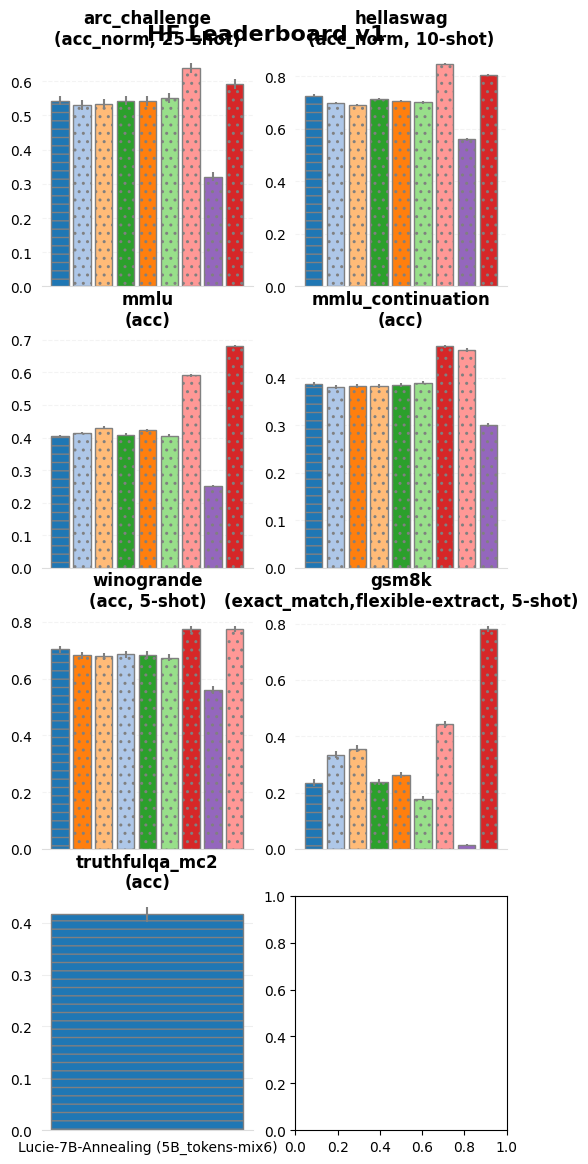

In [16]:
restrict_to = [
    ('Lucie-7B', '3_annealing', '5B_tokens-mix6'),
    ('Lucie-7B', '4_instruct_full', None),
    ('Baseline', '4_instruct_full', None),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        directory = os.path.join(OUTPUT_FOLDER, 'lucie_instruct_full_vs_baselines')
        os.makedirs(directory, exist_ok=True)
        filename = os.path.join(directory ,slugify.slugify(title) + ".png")

    plot_results(results, title, dataset_names, filename, restrict_to, bar_plot=True, xlogscale=False)

In [ ]:
restrict_to = [
    #('Baseline', '4_instruct_full', None),
    ('Lucie-7B', '1_main', None),
    ('Lucie-7B', '4_instruct_lora', 'mix1'),
    ('Lucie-7B', '4_instruct_full', 'mix1'),
    #('Lucie-7B', '4_instruct_lora', 'mix2a'),
    ('Lucie-7B', '4_instruct_lora', 'mix2b'),
    ('Lucie-7B', '4_instruct_full', 'mix2b'),
    ('Lucie-7B', '4_instruct_lora', 'mix3'),
    ('Lucie-7B', '4_instruct_full', 'mix3'),
    ('Lucie-7B', '4_instruct_lora', 'mix4'),
    ('Lucie-7B', '4_instruct_full', 'mix4')
    #('Lucie-7B', '4_instruct_full', 'mix5'),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        directory = os.path.join(OUTPUT_FOLDER, 'lucie_instruct_lora_vs_full_vs_baselines')
        os.makedirs(directory, exist_ok=True)
        filename = os.path.join(directory ,slugify.slugify(title) + ".png")

    plot_results(results, title, dataset_names, filename, restrict_to, bar_plot=True, xlogscale=False)

Saving ../figs/lucie_instruct_lora_vs_full_vs_baselines/hf-leaderboard-v1.png...
Saving ../figs/lucie_instruct_lora_vs_full_vs_baselines/hf-leaderboard-v2.png...
Saving ../figs/lucie_instruct_lora_vs_full_vs_baselines/french-bench.png...
Saving ../figs/lucie_instruct_lora_vs_full_vs_baselines/french-bench-generative.png...
Saving ../figs/lucie_instruct_lora_vs_full_vs_baselines/multilingual-arc-benchmark.png...
Saving ../figs/lucie_instruct_lora_vs_full_vs_baselines/mmmmlu.png...
Saving ../figs/lucie_instruct_lora_vs_full_vs_baselines/hf-openllmfrenchleaderboard.png...


In [ ]:
restrict_to = [
    #('Baseline', '4_instruct_full', None),
    #('Lucie-7B', '1_main', None),
    ('Lucie-7B', '4_instruct_lora', 'mix1'),
    ('Lucie-7B', '4_instruct_lora', 'R1'),
    ('Lucie-7B', '4_instruct_lora', 'mix2a'),
    ('Lucie-7B', '4_instruct_lora', 'R2a'),
    ('Lucie-7B', '4_instruct_lora', 'R2afp'),
    ('Lucie-7B', '4_instruct_lora', 'mix2b'),
    ('Lucie-7B', '4_instruct_lora', 'R2bfp'),
    #('Lucie-7B', '4_instruct_lora', 'mix3'),
    ('Lucie-7B', '4_instruct_lora', 'mix4'),
    ('Lucie-7B', '4_instruct_lora', 'R7m4fp')
    #('Lucie-7B', '4_instruct_full', 'mix5'),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        directory = os.path.join(OUTPUT_FOLDER, 'lucie_instruct_lora_comma_vs_nocomma')
        os.makedirs(directory, exist_ok=True)
        filename = os.path.join(directory ,slugify.slugify(title) + ".png")

    plot_results(results, title, dataset_names, filename, restrict_to, bar_plot=True, xlogscale=False)


Saving ../figs/lucie_instruct_lora_comma_vs_nocomma/hf-leaderboard-v1.png...
Saving ../figs/lucie_instruct_lora_comma_vs_nocomma/hf-leaderboard-v2.png...
Saving ../figs/lucie_instruct_lora_comma_vs_nocomma/french-bench.png...
Saving ../figs/lucie_instruct_lora_comma_vs_nocomma/french-bench-generative.png...
Saving ../figs/lucie_instruct_lora_comma_vs_nocomma/multilingual-arc-benchmark.png...
Saving ../figs/lucie_instruct_lora_comma_vs_nocomma/mmmmlu.png...
Saving ../figs/lucie_instruct_lora_comma_vs_nocomma/hf-openllmfrenchleaderboard.png...


In [ ]:
restrict_to = [
    ('Baseline', '4_instruct_full', None),
    #('Baseline', '4_instruct_full', None),
    ('Lucie-7B', '1_main', None),
    ('Lucie-7B', '4_instruct_full', 'mix1'), # Lucie-7B-Instruct-human-data
    #('Lucie-7B', '4_instruct_lora', 'R1'),
    #('Lucie-7B', '4_instruct_full', 'mix2b'),
    #('Lucie-7B', '4_instruct_lora', 'R2a'),
    #('Lucie-7B', '4_instruct_lora', 'R2afp'),
    #('Lucie-7B', '4_instruct_full', 'mix'),
    #('Lucie-7B', '4_instruct_lora', 'R2bfp'),
    #('Lucie-7B', '4_instruct_lora', 'mix3'),
    #('Lucie-7B', '4_instruct_full', 'mix3'),
    ('Lucie-7B', '4_instruct_full', 'mix4'), # Lucie-7B-Instruct
    #('Lucie-7B', '4_instruct_lora', 'R7m4fp')
    #('Lucie-7B', '4_instruct_full', 'mix5'),
]

for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        directory = os.path.join(OUTPUT_FOLDER, 'lucie_instruct_paper')
        os.makedirs(directory, exist_ok=True)
        filename = os.path.join(directory ,slugify.slugify(title) + ".png")

    plot_results(results, title, dataset_names, filename, restrict_to, bar_plot=True, xlogscale=False)

Saving ../figs/lucie_instruct_paper/hf-leaderboard-v1.png...
Saving ../figs/lucie_instruct_paper/hf-leaderboard-v2.png...
Saving ../figs/lucie_instruct_paper/french-bench.png...
Saving ../figs/lucie_instruct_paper/french-bench-generative.png...
Saving ../figs/lucie_instruct_paper/multilingual-arc-benchmark.png...
Saving ../figs/lucie_instruct_paper/mmmmlu.png...
Saving ../figs/lucie_instruct_paper/hf-openllmfrenchleaderboard.png...
